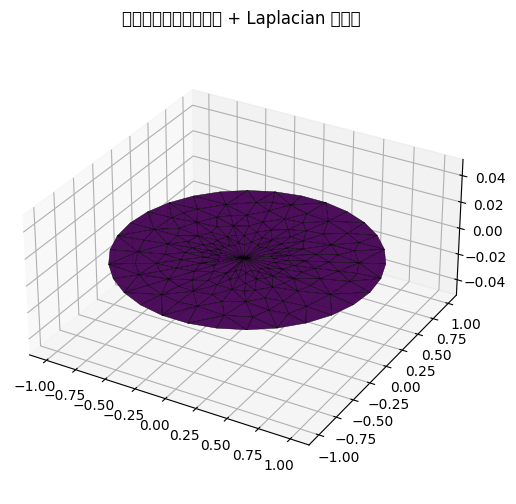

In [4]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. 创建边界：单位圆
theta = np.linspace(0, 2 * np.pi, 30, endpoint=False)
boundary = np.stack([np.cos(theta), np.sin(theta)], axis=1)

# 2. 添加内部点：多个环形层
points = boundary.copy()
for r in np.linspace(0.1, 0.9, 5):
    for t in theta:
        points = np.vstack([points, [r * np.cos(t), r * np.sin(t)]])

# 3. 三角剖分
tri = Delaunay(points)
faces = tri.simplices
vertices = np.hstack([points, np.zeros((points.shape[0], 1))])  # z = 0 初始平面

# 4. 标记边界点（固定）
def is_boundary(pt):
    return np.linalg.norm(pt[:2]) > 0.99

is_fixed = np.array([is_boundary(p) for p in vertices])

# 5. 简单优化：Laplacian smoothing
def laplacian_smooth(vertices, faces, is_fixed, iterations=100, alpha=0.1):
    from collections import defaultdict
    adjacency = defaultdict(set)
    for f in faces:
        for i in range(3):
            adjacency[f[i]].update([f[(i+1)%3], f[(i+2)%3]])  
    new_vertices = vertices.copy()
    for _ in range(iterations):
        for i in range(len(vertices)):
            if is_fixed[i]: continue
            neighbors = list(adjacency[i])
            if not neighbors: continue
            avg = np.mean(vertices[neighbors], axis=0)
            new_vertices[i] += alpha * (avg - new_vertices[i])
        vertices = new_vertices.copy()
    return vertices


# 6. 优化内部顶点
vertices = laplacian_smooth(vertices, faces, is_fixed)

# 7. 可视化
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# 提取x, y, z
x = vertices[:,0]
y = vertices[:,1]
z = vertices[:,2]
triangles = faces

ax.plot_trisurf(x, y, triangles, z, cmap='viridis', edgecolor='k', linewidth=0.3, alpha=0.95)
ax.set_title("近似极小曲面（三角化 + Laplacian 平滑）")
ax.set_box_aspect([1,1,0.5])
plt.show()


/Users/victor/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22235 (\N{CJK UNIFIED IDEOGRAPH-56DB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/victor/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/victor/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/victor/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/victor/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarni

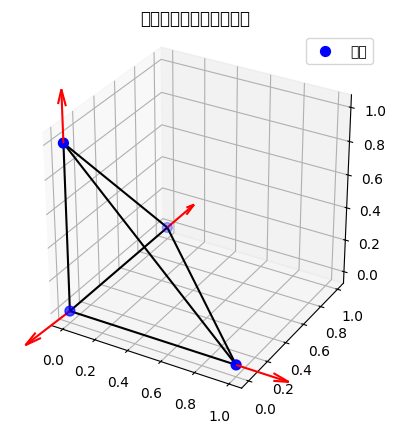

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# === 四面体体积公式 ===
def tetrahedron_volume(p0, p1, p2, p3):
    return abs(np.dot(np.cross(p1 - p0, p2 - p0), p3 - p0)) / 6

# === 数值梯度计算 ===
def volume_gradient(body_points, idx, epsilon=1e-6):
    grad = np.zeros(3)
    base_volume = tetrahedron_volume(*body_points)
    for i in range(3):
        perturbed = body_points.copy()
        perturbed[idx][i] += epsilon
        new_volume = tetrahedron_volume(*perturbed)
        grad[i] = (new_volume - base_volume) / epsilon
    return grad

# === 初始顶点和目标体积 ===
vertices = np.array([
    [0.0, 0.0, 0.0],  # v0
    [1.0, 0.0, 0.0],  # v1
    [0.0, 1.0, 0.0],  # v2
    [0.0, 0.0, 1.0],  # v3
])
bodies = [[0, 1, 2, 3]]
target_volumes = [0.2]

# === 构建线性系统 A * lambda = b ===
A = []
b = []
gradients = {i: np.zeros(3) for i in range(len(vertices))}

for body_idx, (i0, i1, i2, i3) in enumerate(bodies):
    body_pts = vertices[[i0, i1, i2, i3]]
    grads = []
    indices = [i0, i1, i2, i3]
    for vi in range(4):
        g = volume_gradient(body_pts, vi)
        grads.append(g)
        gradients[indices[vi]] += g  # accumulate for each vertex
    grads = np.array(grads)
    A_body = np.sum(grads @ grads.T)
    A.append([A_body])
    current_volume = tetrahedron_volume(*body_pts)
    deficit = target_volumes[body_idx] - current_volume
    b.append([deficit])

A = np.array(A)
b = np.array(b)
lambdas = np.linalg.solve(A, b)

# === 应用拉格朗日修正 ===
forces = np.zeros_like(vertices)
for vi, force in gradients.items():
    forces[vi] += lambdas[0, 0] * force

# === 可视化 ===
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("四面体与拉格朗日修正力")
ax.set_box_aspect([1,1,1])  # 保持长宽高比

# 绘制四面体的边
edges = [(0,1), (1,2), (2,0), (0,3), (1,3), (2,3)]
for i, j in edges:
    xs, ys, zs = vertices[[i, j]].T
    ax.plot(xs, ys, zs, 'k-')

# 绘制顶点
ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c='blue', s=50, label='顶点')

# 绘制力向量
for i in range(len(vertices)):
    x, y, z = vertices[i]
    u, v, w = forces[i]
    ax.quiver(x, y, z, u, v, w, color='red', length=0.3, normalize=True)

ax.legend()
plt.show()
